<a href="https://colab.research.google.com/github/zheminzhang96/CSE573_project/blob/main/lstm_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
%cd /content/drive/Shareddrives/CSE573/preprocessed
%ls

/content/drive/Shareddrives/CSE573/preprocessed
AaplAmzn_NewsDateDirection.csv
Aapl_NewsPriceHistDirection.csv
Aapl_SentimentAggMeanPriceHistDirection.csv
Aapl_SentimentAggSumPriceHistDirection.csv
Amzn_NewsPriceHistDirection.csv
Amzn_SentimentAggMeanPriceHistDirection.csv
Amzn_SentimentAggSumPriceHistDirection.csv
amzn_title_processedText_direction.csv
amzn_title_text_label.csv


In [ ]:
!pip install keras
!pip install matplotlib-venn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import TimeSeriesSplit, train_test_split, KFold, cross_validate

import requests
import io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def split_generator(df):
  cv=[]
  df['prediction_date'] = pd.to_datetime(df['prediction_date'], errors='coerce')
  groups = df.groupby(df['prediction_date'].dt.to_period("M")).groups
  split_groups = [value for (key, value) in groups.items()] 

  print('spilt number:' + str(len(split_groups)))
  for i in range(len(split_groups)):
    data_index=[]
    for j in range(len(split_groups)):
      if i != j:
        data_index.extend(split_groups[j].tolist())
    cv.append((data_index, split_groups[i].tolist()))
    # yield data_index, split_groups[i].tolist()
  
  return cv

In [ ]:
# df_aapl = pd.read_csv('Aapl_SentimentAggMeanPriceHistDirection.csv', nrows=5000)
# df_amzn = pd.read_csv('Amzn_SentimentAggMeanPriceHistDirection.csv', nrows=5000)
# df = [df_aapl, df_amzn]
# df = pd.concat(df, ignore_index=True)
# df = df.replace(-1, 0)
# df
df_aapl = pd.read_csv('Aapl_NewsPriceHistDirection.csv', nrows=5000)
df_amzn = pd.read_csv('Amzn_NewsPriceHistDirection.csv', nrows=5000)

In [ ]:
df_amzn

,uuid,author,url,title,language,text,published,title_aapl,text_aapl,title_amzn,...,prevClose_16,prevClose_17,prevClose_18,prevClose_19,prevClose_20,prevClose_21,prevClose_22,prevClose_23,prevClose_24,prevClose_25
0,3b7327f6858be72e780b02b863d941fe7ce81eab,NaN,https://money.cnn.com/2018/09/05/investing/pre...,6 things to know before the opening bell,english,Click chart for more in-depth data. 1. Big Tec...,2018-09-05 05:12:00+00:00,False,True,False,...,1896.99,1885.99,1896.00,1882.98,1861.48,1847.11,1822.94,1833.98,1796.14,1787.38
1,8a3015a274df99d231fcf7ff3eb38e2660a984ff,Michael Wiggins De Oliveira,https://seekingalpha.com/article/4203857-netfl...,"Netflix And The Competition - Netflix, Inc. (N...",english,Investment Thesis Netflix ( NFLX ) is a remark...,2018-09-04 15:00:00+00:00,False,True,False,...,1896.99,1885.99,1896.00,1882.98,1861.48,1847.11,1822.94,1833.98,1796.14,1787.38
2,df5883d078ebfbe015e1e717002e4b889647dbee,Larry Ramer,https://investorplace.com/2018/09/pandora-stoc...,Pandora Stock Gets a Boost — Buy Now,english,MannKind Surges More Than 50% >>> READ MORE\nB...,2018-09-04 16:22:00+00:00,False,True,False,...,1896.99,1885.99,1896.00,1882.98,1861.48,1847.11,1822.94,1833.98,1796.14,1787.38
3,861c19bff56d09f97b6798f5fbe374061e8aa55b,morningstar.com,http://news.morningstar.com/all/dow-jones/us-m...,MARKET SNAPSHOT: Tech Tumble Weighs On Stocks;...,english,"By Mark DeCambre, MarketWatch , Ryan Vlastelic...",2018-09-05 00:00:00+00:00,False,True,False,...,1896.99,1885.99,1896.00,1882.98,1861.48,1847.11,1822.94,1833.98,1796.14,1787.38
4,cb960bebc2bf78d327026127c9fe919a4159e80d,morningstar.com,http://news.morningstar.com/all/benzinga/BenzB...,"New Month, Same Old Story: Trade Fears Persist...",english,"It may be a new month, but the same trade conc...",2018-09-05 00:00:00+00:00,False,True,False,...,1896.99,1885.99,1896.00,1882.98,1861.48,1847.11,1822.94,1833.98,1796.14,1787.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,66859aec5d156692020efc397f0bb1ee77dd95ef,Reuters Editorial,https://in.reuters.com/article/spotify-subscri...,Spotify reaches 70 million subscribers,english,"January 5, 2018 / 12:29 AM / Updated 17 hours ...",2018-01-04 19:29:00+00:00,False,True,False,...,1164.00,1168.00,1161.32,1160.00,1152.99,1140.97,1132.97,1161.50,1175.50,1161.03
4996,ea42f789f3c01a17131686ef56eadd4a283867f3,NaN,https://www.sott.net/article/373119-Major-chip...,Major chip flaw leaves billions of devices vul...,english,"Thu, 04 Jan 2018 14:44 UTC Two major flaws in ...",2018-01-05 12:29:00+00:00,False,True,False,...,1164.00,1168.00,1161.32,1160.00,1152.99,1140.97,1132.97,1161.50,1175.50,1161.03
4997,5950e8efe7f42e768986e9dd49d94d013b3de8b6,Alexis Leondis,http://www.msn.com/en-us/money/markets/trump-a...,Trump administration might push back against s...,english,Trump administration might push back against s...,2018-01-05 00:00:00+00:00,False,True,False,...,1164.00,1168.00,1161.32,1160.00,1152.99,1140.97,1132.97,1161.50,1175.50,1161.03
4998,d3cf3effab2e2e9a94dd3123d0e42fe57d598493,Elizabeth Balboa,http://www.marketwatch.com/story/7-top-picks-f...,7 Top Picks For 2018 And Their Corresponding ETFs,english,Traders are busy building out brackets for 201...,2018-01-05 00:00:00+00:00,False,True,False,...,1164.00,1168.00,1161.32,1160.00,1152.99,1140.97,1132.97,1161.50,1175.50,1161.03


In [ ]:
# aapl = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/preprocessed/Aapl_NewsPriceHistDirection.csv', nrows=5000)
# aapl.shape
# print('AAPL:')
# aapl.head()

#group by year-month
aapl_cv=split_generator(df_aapl)
# print(aapl_cv)

# amzn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/preprocessed/Amzn_NewsPriceHistDirection.csv', nrows=5000)
# amzn.shape
# print('AMZN:')
# amzn.head()

#group by year-month
amzn_cv=split_generator(df_amzn)

# print(amzn_cv)


spilt number:3
spilt number:7


In [ ]:
!pip install scikeras
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

#def lstm_model(TrainX, TrainY):
def lstm_model(shape):
  layers = [LSTM(128,input_shape=(1,shape),dropout=0.2), Dense(2)]
  model = tf.keras.models.Sequential(layers)
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
  keras_clf = KerasClassifier(model = model, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(), epochs=40, batch_size=64, verbose=0,validation_split=0.2)

  #predictions = cross_val_predict(keras_clf, TrainX, trainY, cv=3)
  return keras_clf

In [ ]:
def lstm_cv(df, stock, desc, features, label, cv, print_summary=False, print_box_plot=False):
    print('Running: ', len(features))
    X = df[features].to_numpy()
    y = (df[label] + 1) / 2
    model = lstm_model(X.shape[1])
    print(X.shape)
    TrainX = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    #print("TrainX: ", TrainX)
    #class_label = pd.get_dummies(y).values
    #model = lstm_model(trainX=X, trainY = class_label)
    
    print("model: ", model)

    results = pd.DataFrame(
        cross_validate(model, TrainX, y, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1']))

    if print_box_plot:
        results.drop('fit_time', axis=1).plot.box(figsize=(10, 5))

    summary = results.describe()
    if print_summary:
        print(summary.loc['mean', :])

    summary = summary.loc['mean', :]
    summary['stock'] = stock
    summary['desc'] = desc
    #print(summary.shape)
    return summary

In [ ]:
prevClose = [
    'prevClose_1',
    'prevClose_2',
    'prevClose_3',
    'prevClose_4',
    'prevClose_5',
    'prevClose_6',
    'prevClose_7',
    'prevClose_8',
    'prevClose_9',
    'prevClose_10',
    'prevClose_11',
    'prevClose_12',
    'prevClose_13',
    'prevClose_14',
    'prevClose_15',
    'prevClose_16',
    'prevClose_17',
    'prevClose_18',
    'prevClose_19',
    'prevClose_20',
    'prevClose_21',
    'prevClose_22',
    'prevClose_23',
    'prevClose_24',
    'prevClose_25'
]
label = 'direction'

aapl_prevClose_accuracies = []
amzn_prevClose_accuracies = []
#print(aapl_cv.shape)
for i in range(len(prevClose)):
    precClose_feat = prevClose[0:i+1]
    #print(df_aapl[precClose_feat].to_numpy())
    aapl_prevClose_accuracies.append(lstm_cv(df_aapl, 'AAPL', f'{i+1} days close price', precClose_feat, label, aapl_cv)['test_accuracy'])
    amzn_prevClose_accuracies.append(lstm_cv(df_amzn, 'AMZN', f'{i+1} days close price', precClose_feat, label, amzn_cv)['test_accuracy'])

Running:  1
(5000, 1)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51faecee50>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51faea5750>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f998fe90>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being s

Running:  1
(5000, 1)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51faebd5d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51efc971d0>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51ef34ca10>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  2
(5000, 2)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51ef2b0610>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51ed911790>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f7d1fad0>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  2
(5000, 2)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f7d38450>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51ef2dc710>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f776aa50>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  3
(5000, 3)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51fa2aad90>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51fcc57ad0>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f914bfd0>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  3
(5000, 3)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51fa653990>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51fc706ad0>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51fc706cd0>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  4
(5000, 4)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51efb94110>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51eda7dfd0>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51fbc76850>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  4
(5000, 4)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51fc4d5110>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51ef0b6c10>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f01567d0>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  5
(5000, 5)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51fac1b0d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51eee86390>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51ede77950>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  5
(5000, 5)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51faa04b90>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51ed741c90>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51fa63e410>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  6
(5000, 6)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f69fea50>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f6b5a590>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f77cdd90>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  6
(5000, 6)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51fa19d390>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f90204d0>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f7d31a10>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  7
(5000, 7)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51fcac5850>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f042b750>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f777cc90>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

Running:  7
(5000, 7)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51ee599c90>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51ee01ed50>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51fc481450>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  8
(5000, 8)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51efc687d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f6776390>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51fc70ca90>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  8
(5000, 8)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51ff711a10>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51ed8f5410>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f6d89d50>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  9
(5000, 9)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51edbc2f90>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f9db7910>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51edf61e90>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  9
(5000, 9)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f6730990>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51ef0a1a90>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51ee1c7cd0>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  10
(5000, 10)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f5204fbbf90>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51faa239d0>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51ef08c8d0>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  10
(5000, 10)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f5204b787d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f79cab90>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51edcea4d0>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  11
(5000, 11)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f9c2e2d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f002db50>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f03ee990>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  11
(5000, 11)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51fc596d10>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51ed862990>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51edda3090>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  12
(5000, 12)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f03ee990>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51faad47d0>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f7c9c510>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

Running:  12
(5000, 12)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f5cef7d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51fece6c50>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f3fffd50>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  13
(5000, 13)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51fe6e0690>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f3f38450>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51fcb6c750>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  13
(5000, 13)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f40c6150>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51fc6e9c10>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51fc6e9bd0>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  14
(5000, 14)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f9b03f10>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51fa443d90>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51edcd1f90>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  14
(5000, 14)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51fc73e4d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51ef0b5f10>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f696d350>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  15
(5000, 15)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f7662f10>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f44ad550>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51ee4bc510>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

Running:  15
(5000, 15)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51fc4cf450>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51fe580050>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51faafb190>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  16
(5000, 16)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51ed9fb610>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f9d45a90>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51fe6d6c90>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  16
(5000, 16)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51ef2a9990>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51ee16c950>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51edc449d0>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  17
(5000, 17)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f04e3ad0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51ede166d0>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f6b4d150>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  17
(5000, 17)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f42ac6d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51fe8cb9d0>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f0146d50>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  18
(5000, 18)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51ee28f110>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f9acdc50>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51edaa2b10>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

Running:  18
(5000, 18)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f02eb090>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51fad1cad0>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f00de850>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  19
(5000, 19)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f4114fd0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51fc75b590>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f4008e90>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  19
(5000, 19)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51fab18b10>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51ee069fd0>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f9adc650>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  20
(5000, 20)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51fe9afcd0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51ef00a410>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51fcb81250>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  20
(5000, 20)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f0630c90>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f6a88a10>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51ef27a410>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  21
(5000, 21)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f5204fd8250>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51ee1fe410>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f8f7fb10>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  21
(5000, 21)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f68eb390>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f4100dd0>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f6a882d0>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  22
(5000, 22)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51edbc2110>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f7bb4650>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51fb86e1d0>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  22
(5000, 22)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f40490d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51ee2d1f10>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51eefc1210>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  23
(5000, 23)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51f00ee350>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f7b4ef90>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51fbd49dd0>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being s

Running:  23
(5000, 23)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51eda4e410>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f6ccd350>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51fc500e10>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  24
(5000, 24)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51fbd49dd0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51faad4f50>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51ee3c2d50>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  24
(5000, 24)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51ee45ec90>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51fbce8c90>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51edb572d0>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  25
(5000, 25)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51ef328150>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f69bd950>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f42fc610>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running:  25
(5000, 25)
model:  KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f51fc879990>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f51f41a0d50>
	loss=<keras.losses.SparseCategoricalCrossentropy object at 0x7f51f7976a90>
	metrics=['accuracy']
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=40
	class_weight=None
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


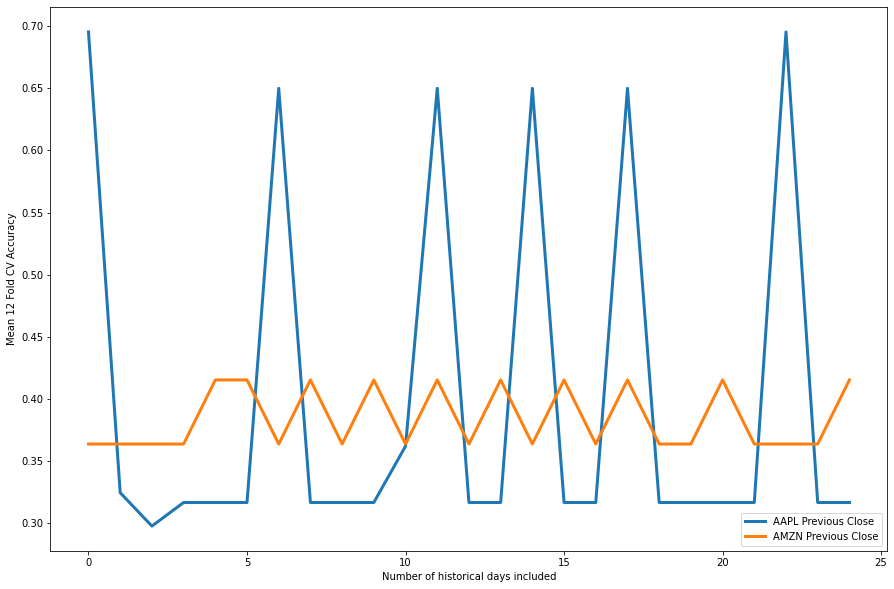

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
_ = ax.plot(aapl_prevClose_accuracies, label='AAPL Previous Close', linewidth=3)
_ = ax.plot(amzn_prevClose_accuracies, label='AMZN Previous Close', linewidth=3)
_ = ax.legend()
_ = ax.set_ylabel('Mean 12 Fold CV Accuracy')
_ = ax.set_xlabel('Number of historical days included')

In [ ]:
prev_price = np.empty(0)
i = 0
for i in range(len(df)):
  prev_price = np.append(prev_price, df.iloc[i][81])
  prev_price = np.append(prev_price, df.iloc[i][82])
  prev_price = np.append(prev_price, df.iloc[i][83])
  prev_price = np.append(prev_price, df.iloc[i][84])
  prev_price = np.append(prev_price, df.iloc[i][85])
  prev_price = np.append(prev_price, df.iloc[i][86])
  prev_price = np.append(prev_price, df.iloc[i][87])
  prev_price = np.append(prev_price, df.iloc[i][88])
  prev_price = np.append(prev_price, df.iloc[i][89])
  prev_price = np.append(prev_price, df.iloc[i][90])
  prev_price = np.append(prev_price, df.iloc[i][91])
  prev_price = np.append(prev_price, df.iloc[i][92])
  prev_price = np.append(prev_price, df.iloc[i][93])
  prev_price = np.append(prev_price, df.iloc[i][94])
  prev_price = np.append(prev_price, df.iloc[i][95])
  prev_price = np.append(prev_price, df.iloc[i][96])
  prev_price = np.append(prev_price, df.iloc[i][97])
  prev_price = np.append(prev_price, df.iloc[i][98])
  prev_price = np.append(prev_price, df.iloc[i][99])
  prev_price = np.append(prev_price, df.iloc[i][100])
  prev_price = np.append(prev_price, df.iloc[i][101])
  prev_price = np.append(prev_price, df.iloc[i][102])
  prev_price = np.append(prev_price, df.iloc[i][103])
  prev_price = np.append(prev_price, df.iloc[i][104])
  prev_price = np.append(prev_price, df.iloc[i][105])
  #print(len(prev_price))
  i = i+1
  #print(i)
prev_price.shape
prev_price = np.reshape(prev_price, (566,25))
print(prev_price[0])
print(prev_price.shape)

[169.37 168.79 169.56 169.56 170.96 171.64 169.19 172.98 174.08 174.94
 174.9  173.   169.89 170.02 171.15 169.22 171.05 173.86 174.64 175.89
 176.66 174.71 174.1  172.45 173.61]
(566, 25)


In [ ]:
direction = []

for l in df['direction']:
  direction.append(l)
print(len(direction))
#direction

566


In [ ]:
class_label = pd.get_dummies(direction).values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(prev_price, class_label, test_size=0.2, random_state=56)

In [ ]:
TrainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
TestX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
TrainX = TrainX.astype('float64')
TestX = TestX.astype('float64')

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dense

In [ ]:
from keras.optimizers import Adam
layers = [LSTM(128,input_shape=(1,TrainX.shape[2]),dropout=0.2), Dense(2,activation='sigmoid')]
model = tf.keras.models.Sequential(layers)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])
model.fit(TrainX, Y_train, epochs=40, batch_size=64, verbose=2,validation_split=0.2)

Epoch 1/40
6/6 - 3s - loss: 0.7038 - accuracy: 0.5125 - val_loss: 0.6905 - val_accuracy: 0.5385 - 3s/epoch - 501ms/step
Epoch 2/40
6/6 - 0s - loss: 0.7304 - accuracy: 0.4709 - val_loss: 0.6891 - val_accuracy: 0.5495 - 67ms/epoch - 11ms/step
Epoch 3/40
6/6 - 0s - loss: 0.7214 - accuracy: 0.4986 - val_loss: 0.6877 - val_accuracy: 0.5165 - 76ms/epoch - 13ms/step
Epoch 4/40
6/6 - 0s - loss: 0.7244 - accuracy: 0.4848 - val_loss: 0.6926 - val_accuracy: 0.5275 - 70ms/epoch - 12ms/step
Epoch 5/40
6/6 - 0s - loss: 0.7104 - accuracy: 0.5125 - val_loss: 0.6929 - val_accuracy: 0.5275 - 75ms/epoch - 13ms/step
Epoch 6/40
6/6 - 0s - loss: 0.7039 - accuracy: 0.5291 - val_loss: 0.6952 - val_accuracy: 0.4396 - 65ms/epoch - 11ms/step
Epoch 7/40
6/6 - 0s - loss: 0.7136 - accuracy: 0.5069 - val_loss: 0.7015 - val_accuracy: 0.4725 - 66ms/epoch - 11ms/step
Epoch 8/40
6/6 - 0s - loss: 0.7057 - accuracy: 0.5069 - val_loss: 0.6973 - val_accuracy: 0.4725 - 67ms/epoch - 11ms/step
Epoch 9/40
6/6 - 0s - loss: 0.715

In [ ]:
model.evaluate(TestX, Y_test, verbose=2)

4/4 - 0s - loss: 0.6915 - accuracy: 0.5263 - 29ms/epoch - 7ms/step


[0.6914852857589722, 0.5263158082962036]